<a href="https://colab.research.google.com/github/mille055/AIPI540_individual_project/blob/main/notebooks/AIPI540_IP_fusion_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

In [1]:
COLAB_FLAG = False   # whether running on colab or locally on computer

In [120]:
if COLAB_FLAG:
    !pip install pydicom==2.1.2
    !pip install monai seaborn sentence_transformers
    !git clone 'https://github.com/mille055/AIPI540_individual_project.git'

    


In [236]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import monai
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GroupKFold, cross_val_score, cross_validate, GroupShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime
from sentence_transformers import SentenceTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from datetime import datetime
from pprint import pprint


import monai
from monai.data import DataLoader, ImageDataset
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, EnsureType
from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import warnings
warnings.filterwarnings("ignore")

In [238]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/AIPI540_individual_project/scripts/')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/AIPI540_individual_project/scripts/')

### local imports ###
from config import file_dict, feats, column_lists, RF_parameters, classes
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from config import sentence_encoder, series_description_column
from utils import *
from train_pixel_model import train_pix_model, test_pix_model
from train_meta_model import train_fit_parameter_trial, train_meta_model, calc_feature_importances
from train_text_model import train_text_log_model, load_text_data

# from AIPI540_individual_project.scripts.train_pixel_model import train_model
# from AIPI540_individual_project.scripts.train_text_model import load_text_data, train_text_model, list_incorrect_text_predictions
# from AIPI540_individual_project.scripts.utils import *

ImportError: cannot import name 'train_text_log_model' from 'train_text_model' (/Users/cmm/Documents/GitHub/AIPI540_individual_project/scripts/train_text_model.py)

# Load Datasets


In [5]:
if COLAB_FLAG:
    train_datafile = '/content/AIPI540_individual_project/data/trainfiles.csv'
    val_datafile = '/content/AIPI540_individual_project/data/valfiles.csv'
    test_datafile = '/content/AIPI540_individual_project/data/testfiles.csv'
else:
    # for local
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'

In [52]:
# ## exclude and write back to csv....
# excluded = [21,22,26,27,28,29, 1, 10, 15, 20]
# t = pd.read_csv(train_datafile)
# v = pd.read_csv(val_datafile)
# te = pd.read_csv(test_datafile)

# t = t[~t.label.isin(excluded)]
# v = v[~v.label.isin(excluded)]
# te = te[~te.label.isin(excluded)]
# # t = pool_arterial_labels(t)
# # v = pool_arterial_labels(v)
# # te = pool_arterial_labels(te)

# t.to_csv('../data/trainfiles_mod.csv', index=False)
# v.to_csv('../data/valfiles_mod.csv', index=False)
# te.to_csv('../data/testfiles_mod.csv', index=False)

In [195]:
# train, val, test = load_csv_dataset(train_datafile, test_datafile, val_lists = val_list)
# train = shorten_df(train)
# val = shorten_df(val)
# test = shorten_df(test)

train_full = pd.read_csv(train_datafile)
val_full = pd.read_csv(val_datafile)
test_full = pd.read_csv(test_datafile)

train = shorten_df(train_full)
val = shorten_df(val_full)
test = shorten_df(test_full)

In [197]:

train_df = prepare_df(train)
val_df = prepare_df(val)
test_df = prepare_df(test)



In [198]:
train_df

,ImageType,SOPClassUID,SeriesDescription,ContrastBolusAgent,BodyPartExamined,ScanningSequence,SequenceVariant,ScanOptions,MRAcquisitionType,AngioFlag,...,PhotometricInterpretation,PixelSpacing,fname,TriggerTime,InversionTime,label,patientID,series,contrast,plane
0,"[DERIVED, PRIMARY, DIFFUSION, TRACEW, DIS2D]",MR Image Storage,ax diff_TRACEW,Multihance,ABDOMEN,EP,"[SK, SP]","[PFP, SFS]",2D,N,...,MONOCHROME2,"[0.9375, 0.9375]",/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/18 (35-68)/0052.dcm,NaN,NaN,8,104,18(35-68),1,ax
1,"[DERIVED, PRIMARY, DIFFUSION, TRACEW, DIS2D]",MR Image Storage,ax diff_TRACEW,Multihance,ABDOMEN,EP,"[SK, SP]","[PFP, SFS]",2D,N,...,MONOCHROME2,"[0.9375, 0.9375]",/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/18 (1-34)/0018.dcm,NaN,NaN,8,104,18(1-34),1,ax
2,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax equilibrium,Multihance,ABDOMEN,GR,"[SP, OSP]","[PFP, FS]",3D,N,...,MONOCHROME2,"[0.703125, 0.703125]",/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/20/0037.dcm,NaN,NaN,16,104,20,1,ax
3,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax haste bh,NaN,ABDOMEN,SE,"[SK, SP, OSP]","[PFP, SAT2, SFS]",2D,N,...,MONOCHROME2,"[1.5625, 1.5625]",/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/9/0017.dcm,NaN,NaN,9,104,9,0,ax
4,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax t2 triggerred,NaN,ABDOMEN,SE,"[SK, SP]","[PFP, SAT2, FS]",2D,N,...,MONOCHROME2,"[1.5625, 1.5625]",/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/11/0017.dcm,NaN,NaN,9,104,11,0,ax
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,cor haste,NaN,ABDOMEN,SE,"[SK, SP, OSP]",PFP,2D,N,...,MONOCHROME2,"[1.5625, 1.5625]",/volumes/cm7/Abdominal_MRI_dataset_split/train/094/exam1/3/0015.dcm,NaN,NaN,7,94,3,0,cor
1365,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax dyn,Multihance,ABDOMEN,GR,"[SP, OSP]","[PFP, FS]",3D,N,...,MONOCHROME2,"[0.78125, 0.78125]",/volumes/cm7/Abdominal_MRI_dataset_split/train/094/exam1/12/0037.dcm,NaN,NaN,2,94,12,1,ax
1366,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax dyn,Multihance,ABDOMEN,GR,"[SP, OSP]","[PFP, FS]",3D,N,...,MONOCHROME2,"[0.78125, 0.78125]",/volumes/cm7/Abdominal_MRI_dataset_split/train/094/exam1/13/0037.dcm,NaN,NaN,2,94,13,1,ax
1367,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax dixon_opp,NaN,ABDOMEN,GR,SP,"[PFP, SAT2]",3D,N,...,MONOCHROME2,"[1.5625, 1.5625]",/volumes/cm7/Abdominal_MRI_dataset_split/train/094/exam1/5/0037.dcm,NaN,NaN,19,94,5,0,ax


In [11]:
X_train_meta = preprocess(train_df)
X_val_meta = preprocess(val_df)
X_test_meta = preprocess(test_df)
y_train = train_df.label
y_val = val_df.label
y_test = test_df.label


Preprocessing metadata for Random Forest classifier.
Have received 1369 entries.
Preprocessing metadata for Random Forest classifier.
Have received 354 entries.
Preprocessing metadata for Random Forest classifier.
Have received 432 entries.


In [12]:
X_test_meta[feats]

,MRAcquisitionType,AngioFlag,SliceThickness,RepetitionTime,EchoTime,EchoTrainLength,PixelSpacing,ContrastBolusAgent,InversionTime,DiffusionBValue,...,opt_T2FLAIR_GEMS,opt_TRF_GEMS,opt_VASCTOF_GEMS,opt_VB_GEMS,opt_W,opt_X,opt__,type_ADC,type_DIFFUSION,type_DERIVED
0,0,1,0.057471,0.388305,0.046865,0.239216,0.87500,1,0.0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,1,0.057471,0.388305,0.046865,0.239216,0.87500,1,0.0,0,...,0,0,0,0,0,0,0,0,1,1
2,1,1,0.034483,0.000064,0.000077,0.000000,0.09375,1,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0.034483,0.000064,0.000077,0.000000,0.09375,1,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0.034483,0.000067,0.000000,0.003922,0.56250,0,0.0,0,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,0,1,0.057471,0.351885,0.046865,0.239216,0.81250,1,0.0,0,...,0,0,0,0,0,0,0,0,1,1
428,0,1,0.057471,0.060522,0.066145,0.313725,0.56250,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
429,1,1,0.034483,0.000064,0.000077,0.000000,0.09375,1,0.0,0,...,0,0,0,0,0,0,0,0,0,0
430,1,1,0.034483,0.000067,0.000949,0.003922,0.56250,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:


feats_to_keep = [col for col in X_train_meta[feats].columns if X_train_meta[col].nunique() > 1]
X_test_meta[feats_to_keep]

,MRAcquisitionType,AngioFlag,SliceThickness,RepetitionTime,EchoTime,EchoTrainLength,PixelSpacing,ContrastBolusAgent,InversionTime,seq_E,...,opt_SEQ_GEMS,opt_SP,opt_T,opt_TRF_GEMS,opt_VASCTOF_GEMS,opt_W,opt_X,type_ADC,type_DIFFUSION,type_DERIVED
0,0,1,0.057471,0.388305,0.046865,0.239216,0.87500,1,0.0,1,...,0,0,0,0,0,0,0,0,1,1
1,0,1,0.057471,0.388305,0.046865,0.239216,0.87500,1,0.0,1,...,0,0,0,0,0,0,0,0,1,1
2,1,1,0.034483,0.000064,0.000077,0.000000,0.09375,1,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0.034483,0.000064,0.000077,0.000000,0.09375,1,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0.034483,0.000067,0.000000,0.003922,0.56250,0,0.0,0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,0,1,0.057471,0.351885,0.046865,0.239216,0.81250,1,0.0,1,...,0,0,0,0,0,0,0,0,1,1
428,0,1,0.057471,0.060522,0.066145,0.313725,0.56250,0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
429,1,1,0.034483,0.000064,0.000077,0.000000,0.09375,1,0.0,0,...,0,0,0,0,0,0,0,0,0,0
430,1,1,0.034483,0.000067,0.000949,0.003922,0.56250,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
### new optimized meta model
meta_model = train_fit_parameter_trial(X_train_meta, y_train, features = feats_to_keep, fname='meta_04152023.skl')


Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 2,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'bootstrap': False,
 'max_depth': 371,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 373}


In [15]:
RF_params = meta_model.get_params()
pprint(RF_params)

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 371,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 373,
 'n_jobs': 2,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


## Get Inferences from Saved Models

In [16]:
def meta_inference(df, model, feature_list=feats):
    X = preprocess(df)[feature_list]
    y = df.label
    preds = model.predict(X)
    probs = model.predict_proba(X)
    acc = np.sum(preds==y)/len(y)


    return preds, probs, y, acc
    

In [17]:
# Load the pickled model
with open('../models/meta_04152023.skl', 'rb') as file:
    meta_model = pickle.load(file)



In [18]:
Tpreds, Tprobs, Ty, Tacc = meta_inference(train_df, meta_model, feats_to_keep)
Vpreds, Vprobs, Vy, Vacc = meta_inference(val_df, meta_model, feats_to_keep)
TEpreds, TEprobs, TEy, TEacc = meta_inference(test_df, meta_model, feats_to_keep)

Preprocessing metadata for Random Forest classifier.
Have received 1369 entries.
Preprocessing metadata for Random Forest classifier.
Have received 354 entries.
Preprocessing metadata for Random Forest classifier.
Have received 432 entries.


In [83]:
def make_results_df(preds, probs, true, df):
    return pd.DataFrame({'preds': preds, 'true': true, 'probs': [row.tolist() for row in probs], 'patientID': df['patientID'], 'series_description': df['SeriesDescription'], 'contrast': df['contrast'], 'plane': df['plane']  })



In [84]:

meta_train_results_df = make_results_df(Tpreds, Tprobs, Ty, train_df)
meta_val_results_df = make_results_df(Vpreds, Vprobs, Vy, val_df)
meta_test_results_df = make_results_df(TEpreds, TEprobs, TEy, test_df)
meta_vector = Tprobs

In [85]:
meta_test_results_df

,preds,true,probs,patientID,series_description,contrast,plane
0,8,8,"[0.03796778940987547, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9349175895879057, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]",102,ax diff_TRACEW,1,ax
1,8,8,"[0.03796778940987547, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9349175895879057, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]",102,ax diff_TRACEW,1,ax
2,6,16,"[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]",102,ax equilibrium new,1,ax
3,6,2,"[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]",102,ax dyn new,1,ax
4,25,25,"[0.0, 0.00174968251728517, 0.016215425842207275, 0.0, 0.0, 0.0, 0.0, 0.008705280421098116, 0.0, 0.00028617730042874675, 0.0, 0.0, 0.0040711661023806345, 0.003753351206434316, 0.0, 0.0008764693751288925, 0.0, 0.00174968251728517, 0.9625927647177517]",102,ax dixon_W,0,ax
...,...,...,...,...,...,...,...
427,8,8,"[0.06388378583525521, 0.0021008630928201974, 0.00138767993995876, 0.0052725647899910634, 0.9090015931625259, 0.0034941413672803286, 0.0, 0.0006702412868632708, 0.0009403762754969188, 6.963545837540476e-05, 0.005764075067024128, 0.0, 0.0027681672540064524, 0.0001300073811964739, 0.0012622148962138171, 0.00040214477211796245, 0.0, 0.0021524796323723937, 0.0007000297885016385]",58,ax diff_TRACEW,1,ax
428,7,7,"[0.0, 0.0, 4.3950248318903e-05, 0.9332484719913836, 0.0, 0.05672983799176568, 0.0, 0.0, 0.0, 0.0, 0.002680965147453083, 0.0, 0.0, 7.867620014653127e-05, 0.0072180984209323, 0.0, 0.0, 0.0, 0.0]",58,cor haste,0,cor
429,6,2,"[0.0, 0.23471321221366984, 0.5210882130741418, 0.0, 0.0, 8.790049663780601e-06, 0.0, 0.00031611283647160375, 0.02406132893297238, 0.01085039853036769, 0.00026968477071439596, 0.0, 0.10090531549530747, 2.0028355974824096e-05, 0.0003840931521153112, 0.00026968477071439596, 0.0, 0.08521936282784692, 0.02189377499003981]",58,ax dyn new,1,ax
430,14,14,"[0.0, 0.011090778532678163, 0.014468261932407724, 0.0, 0.0, 0.00021415835837954424, 0.0, 0.008717730762173442, 0.0, 0.0015705056706787803, 0.596256724545031, 0.0, 0.012431884026275245, 0.0007579391640153514, 0.0, 0.30313238701290063, 8.378016085790885e-05, 0.006695557735911504, 0.04458029209869071]",58,ax dixon_in,0,ax


In [92]:
def display_and_save_results(results_df, classes=classes, fn=''):
   
    y_pred = results_df.preds
    y_true = results_df.true
    class_text_labels = [abd_label_dict[str(x)]['short'] for x in classes]
    # print('preds are of type', y_pred.dtype)
    # print('true are of type', y_true.dtype)

    # # Use isnan() to create a boolean mask for NaN values
    # prednan = np.isnan(y_pred).sum()
    # truenan = np.isnan(y_true).sum()

    # # Print the original array and the boolean mask
    # print(prednan, truenan)


     # Generate a classification report based on the true labels and predicted labels
    print(classification_report(y_true, y_pred))

    # Generate a confusion matrix based on the true labels and predicted labels
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=classes)

    # Create a ConfusionMatrixDisplay object with the correct labels
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.figure(figsize=(25, 25))
    plt.tight_layout()
    #ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.savefig("../assets/FigCM_"+fn+datetime.today().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')     

    return cm      


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.64      0.64      0.64        61
           6       0.23      0.82      0.35        17
           7       0.96      1.00      0.98        22
           8       1.00      1.00      1.00        43
           9       0.98      1.00      0.99        42
          11       0.89      0.83      0.86        29
          12       0.00      0.00      0.00        10
          13       1.00      0.67      0.80         3
          14       1.00      1.00      1.00        23
          16       1.00      0.05      0.09        22
          17       1.00      1.00      1.00        21
          18       1.00      0.93      0.96        28
          19       0.66      0.91      0.76        23
          23       0.00      0.00      0.00        20
          25       0.87      0.83      0.85        47

    accuracy                           0.78       432
   macro avg       0.76   

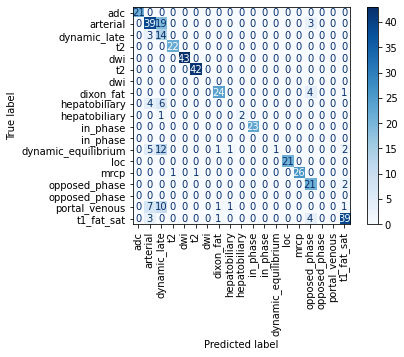

<Figure size 1800x1800 with 0 Axes>

In [93]:
f = display_and_save_results(test_results_df, fn='meta')


Preprocessing metadata for Random Forest classifier.
Have received 432 entries.
accuracy is 0.7754629629629629
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.60      0.64      0.62        61
           6       0.23      0.82      0.35        17
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        43
           9       0.98      1.00      0.99        42
          11       0.81      0.86      0.83        29
          12       0.00      0.00      0.00        10
          13       1.00      0.67      0.80         3
          14       1.00      1.00      1.00        23
          16       1.00      0.05      0.09        22
          17       1.00      1.00      1.00        21
          18       1.00      0.96      0.98        28
          19       0.69      0.87      0.77        23
          23       0.00      0.00      0.00        20
          25       0.88 

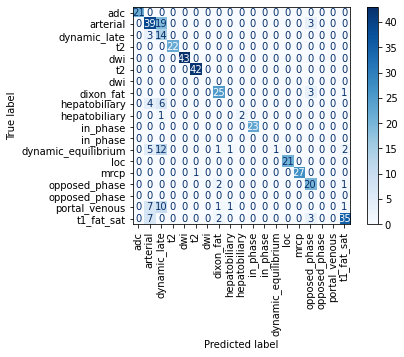

<Figure size 1800x1800 with 0 Axes>

In [61]:
## just checking to make sure the saved model is better than vanilla RF
vanilla_model = RandomForestClassifier(min_samples_leaf=2)
vanilla_model.fit(X_train_meta[feats_to_keep], y_train)
vanillapreds, vanillaprobs, vanillay, vanillaacc = meta_inference(test_df, vanilla_model, feats_to_keep)
print('accuracy is', vanillaacc)
vanilla_results_df = make_meta_results_df(vanillapreds, vanillaprobs, TEy, test_df)
f= display_and_save_results(vanilla_results_df)


It shows no significant change in the overall accuracy compared with the default parameters...

### Getting pixel inference results

In [66]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True) # Load the ResNet50 model 

# Replace the output layer to match the number of output units in your fine-tuned model
num_finetuned_output_units = 30
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, num_finetuned_output_units)

# Load the saved state_dict
state_dict = torch.load('../models/pixel_model_041123.pth', map_location=device)
model.load_state_dict(state_dict)

# Move the model to the appropriate device
model = model.to(device)  


In [67]:
def image_to_tensor(filepath):
    # Define the transformations to match the ones used during training/evaluation of the test dataset
#     test_transform = transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize(299),
#         transforms.CenterCrop(299),
#         transforms.Grayscale(num_output_channels=3),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize the image using the same mean and std values as during training
# ])

    # Load an image and apply the transformations
    #image = Image.open(filepath)
    ds = pydicom.dcmread(filepath)
    img = np.array(ds.pixel_array, dtype=np.float32)
    img = img[np.newaxis]
    img = torch.from_numpy(np.asarray(img))
    input_tensor = data_transforms['test'](img)

    # Add a batch dimension to the input tensor
    input_tensor = input_tensor.unsqueeze(0)
    print('changing input_tensor to shape', input_tensor.shape)
    # Move the input tensor to the appropriate device
    input_tensor = input_tensor.to(device)

    return input_tensor




In [73]:
def get_pixel_preds_and_probs(model, filelist, classes=classes):
    model = model.to(device)
    # Turn autograd off
    with torch.no_grad():
        model.eval()

    preds = []
    probs = []
    
    count = 0
    for file in filelist:
        print('on item ', count, file)
        
        each_tensor = image_to_tensor(file)
        #visualization of a batch of images
        each_tensor = each_tensor.to(device)
        # Feed inputs through model to get raw scores
        logits = model.forward(each_tensor)
        
        
        prob = torch.softmax(logits, dim=1)
        prob = prob.detach().cpu().numpy()
        #print(labels, probs)
        # Get discrete predictions using argmax
        pred = np.argmax(prob)
        # Add predictions and actuals to lists
        preds.append(pred)
        probs.append(prob)
        
       
        # logits = model.forward(each_tensor)
        # # Convert the output to a desired format 
        # output_numpy = output.detach().numpy()
        
        # # Apply the softmax function to convert logits to probabilities
        # probabilities = np.exp(output_numpy) / np.sum(np.exp(output_numpy), axis=1, keepdims=True)

        # # Find the class predictions
        # pred = classes[np.argmax(probabilities, axis=1)]
        # print('predicted class is ', pred)
        # # Store probabilities and predictions
        # probs.append(probabilities)
        # preds.append(pred)

        count+= 1
    # Convert lists to numpy arrays
    predictions_array = np.array(preds).flatten()
    probabilities_array = np.array(probs).squeeze()

    # Print the predictions and probabilities arrays
    print("Predictions array:", predictions_array)
    print("Probabilities array:", probabilities_array)


    return predictions_array, probabilities_array



In [74]:
pixel_train_preds, pixel_train_probs = get_pixel_preds_and_probs(model, train_df.fname.tolist())
pixel_val_preds, pixel_val_probs = get_pixel_preds_and_probs(model, val_df.fname_to_list())
pixel_test_preds, pixel_test_probs = get_pixel_preds_and_probs(model, test_df.fname_to_list())

on item  0 /volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm
changing input_tensor to shape torch.Size([1, 3, 299, 299])
on item  1 /volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (41-80)/0061.dcm
changing input_tensor to shape torch.Size([1, 3, 299, 299])
on item  2 /volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/18/0037.dcm
changing input_tensor to shape torch.Size([1, 3, 299, 299])
on item  3 /volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/11/0037.dcm
changing input_tensor to shape torch.Size([1, 3, 299, 299])
on item  4 /volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/7/0037.dcm
changing input_tensor to shape torch.Size([1, 3, 299, 299])
on item  5 /volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/6/0037.dcm
changing input_tensor to shape torch.Size([1, 3, 299, 299])
on item  6 /volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/17/0021.dcm
changing input_tensor to shape torch.Size([1, 3, 299, 299])
on item  7 /vo

array([ 8,  8, 25,  2, 25, 11,  0, 17,  9,  6,  9, 19, 18, 25,  2,  7,  2,
       14,  2,  9,  2,  9,  8, 25, 14, 16, 16, 19, 17, 11, 11,  6, 16,  2,
       25,  8, 11,  2, 18,  0,  7, 25,  6,  0,  9,  9, 11, 18, 14,  8,  2,
        8, 25,  6, 25, 23,  7,  2, 17,  2, 19,  2, 11, 19, 11,  8,  2, 23,
       18,  9,  8,  8, 14, 11,  0,  2,  2,  6, 23, 17, 25, 16,  9,  0, 25,
       23, 11, 18,  6,  8, 14,  2,  7, 25,  8, 17,  2, 19,  2,  0, 25, 11,
       18, 25,  2,  9,  8,  8, 25, 23, 14,  2,  7, 25, 17,  2, 19,  2,  9,
        6, 25,  0, 18,  9, 17,  2,  8,  8,  6, 23,  2, 11, 14,  7, 19, 25,
        2, 23,  8,  6,  0,  8, 25, 18, 11, 17,  9, 23,  9,  8, 19, 23, 25,
       25,  7, 25, 14,  2,  8,  8, 16,  9,  2, 25,  2,  0, 17,  2,  6, 14,
       18, 19,  2,  7, 23, 11,  9,  8,  0, 18, 25, 14,  2, 19, 23,  9, 11,
       23,  8,  0,  7,  2, 17,  9,  8,  8, 25,  2,  6, 18,  6,  0,  9, 25,
       18, 11,  8, 17,  9, 23,  8,  9, 19, 23, 25, 25,  7, 25, 14, 23,  8,
        9, 11, 23, 25, 23

In [87]:

pixel_test_results_df = make_results_df(preds, probs, TEy, test_df)
pixel_test_results_df

,preds,true,probs,patientID,series_description,contrast,plane
0,8,8,"[1.6852594853844494e-05, 4.270186764188111e-05, 0.0006498766015283763, 1.8740574887488037e-06, 2.590197937024641e-06, 2.67950645138626e-06, 9.560191392665729e-05, 1.3276991921884473e-05, 0.9892963767051697, 0.009439305402338505, 2.9749249733868055e-05, 4.188724051346071e-05, 1.8095772247761488e-05, 7.897721661720425e-05, 8.777221410127822e-06, 9.797938218980562e-06, 3.1867319194134325e-05, 2.4521361410734244e-05, 5.9795518609462306e-05, 3.0928717023925856e-05, 1.791873546608258e-05, 2.0445938844204647e-06, 2.6693655854614917e-06, 5.37081177753862e-05, 2.7414016585680656e-06, 1.689694545348...",102,ax diff_TRACEW,1,ax
1,8,8,"[2.3690865418757312e-05, 3.292050678282976e-05, 0.0001142401815741323, 1.6934028508330812e-06, 2.1930966340732994e-06, 2.5454512524447637e-06, 3.838774864561856e-05, 1.1681226169457659e-05, 0.9908667802810669, 0.008465517312288284, 1.9563380192266777e-05, 1.3232384844741318e-05, 8.485104444844183e-06, 4.647385867428966e-05, 1.922370574902743e-05, 8.863603397912811e-06, 3.522130282362923e-05, 2.7557023713598028e-05, 0.00015601489576511085, 2.512704122636933e-05, 1.5299152437364683e-05, 1.8162345440941863e-06, 2.377550345045165e-06, 2.8068128813174553e-05, 2.359288828301942e-06, 2.2707079551...",102,ax diff_TRACEW,1,ax
2,25,16,"[0.0009319374803453684, 0.021189933642745018, 0.12992273271083832, 0.00015313310723286122, 0.0001939693174790591, 0.00012556224828585982, 0.007518674712628126, 0.0007072100997902453, 0.000705554208252579, 0.006269051227718592, 0.0016752597875893116, 0.03511250019073486, 0.15844538807868958, 0.009591109119355679, 0.00021117771393619478, 0.0012631301069632173, 0.019259098917245865, 0.000312034972012043, 0.009689642116427422, 0.004621067550033331, 0.0015310434391722083, 0.00016095227329060435, 0.00014909378660377115, 0.20182761549949646, 0.00019105682440567762, 0.3876195251941681, 0.000144108...",102,ax equilibrium new,1,ax
3,2,2,"[0.0002593929530121386, 0.0019249471370130777, 0.6442839503288269, 5.280004188534804e-05, 5.8523630286799744e-05, 4.116650598007254e-05, 0.003175861667841673, 0.00013718583795707673, 0.0003173050645273179, 0.001428944175131619, 0.0005458994419313967, 0.0004302964371163398, 0.04644470661878586, 0.0029108694288879633, 0.0002685431682039052, 0.0003435759572312236, 0.001051725004799664, 0.000517616921570152, 0.00040878469008021057, 0.0014182101003825665, 0.00030630972469225526, 6.081880201236345e-05, 5.929542749072425e-05, 0.06271841377019882, 5.6400374887743965e-05, 0.23057176172733307, 4.374...",102,ax dyn new,1,ax
4,25,25,"[4.5246128138387576e-05, 0.0005719485925510526, 0.0015084510669112206, 6.226468485692749e-06, 5.357885584089672e-06, 7.629170795553364e-06, 2.3080301616573706e-05, 1.0780886441352777e-05, 0.00013873758143745363, 0.00044994193012826145, 5.1732811698457226e-05, 0.0023278389126062393, 0.0007451503188349307, 0.00018818695389200002, 0.0005898465169593692, 2.908386341005098e-05, 6.25432949163951e-05, 0.00018911637016572058, 5.2222454542061314e-05, 0.008670455776154995, 4.487351907300763e-05, 5.951091225142591e-06, 7.875243682065047e-06, 4.11872097174637e-05, 8.174412869266234e-06, 0.984194874763...",102,ax dixon_W,0,ax
...,...,...,...,...,...,...,...
427,8,8,"[1.9697299649124034e-05, 2.6812453143065795e-05, 0.00228488864377141, 9.332778176940337e-07, 1.013638552649354e-06, 1.203678493766347e-06, 1.5960900782374665e-05, 4.700244062405545e-06, 0.9951087832450867, 0.0022312516812235117, 1.378587148792576e-05, 1.995984166569542e-05, 1.4247539183998015e-05, 3.611779538914561e-05, 4.227384852129035e-05, 5.010546374251135e-06, 2.2165455447975546e-05, 1.9915956727345474e-05, 2.402396421530284e-05, 5.227259862294886e-06, 9.195410711981822e-06, 9.04064563655993e-07, 1.1086520999015193e-06, 6.014132668497041e-05, 1.0913871619777638e-06, 2.6121322662220336...",58,ax diff_TRACEW,1,ax
428,7,7,"[8.364606401300989e-06, 5.7196120906155556e-05, 8.256400178652257e-06, 5.240218001745234e-07, 6.23932635

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.77      0.79      0.78        61
           6       0.81      1.00      0.89        17
           7       1.00      0.91      0.95        22
           8       0.96      1.00      0.98        43
           9       1.00      0.95      0.98        42
          11       1.00      1.00      1.00        29
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00         3
          14       0.88      0.96      0.92        23
          16       0.80      0.36      0.50        22
          17       0.95      0.95      0.95        21
          18       1.00      1.00      1.00        28
          19       0.88      0.96      0.92        23
          23       0.39      0.65      0.49        20
          25       0.83      0.91      0.87        47

    accuracy                           0.87       432
   macro avg       0.77   

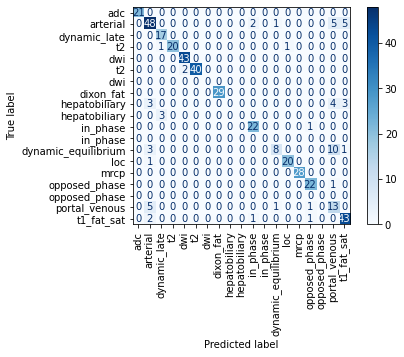

<Figure size 1800x1800 with 0 Axes>

In [94]:
f = display_and_save_results(pixel_test_results_df, fn='pixel')

### Getting NLP inference


In [239]:
# Load the pickled model
with open('../models/text_model20230415.st', 'rb') as file:
    NLP_model = pickle.load(file)

In [124]:
!pip install sentence_transformers

  Using cached sentence_transformers-2.2.2-py3-none-any.whl
     |████████████████████████████████| 7.0 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 200 kB 4.0 MB/s eta 0:00:01
  Using cached tokenizers-0.13.3-cp38-cp38-macosx_10_11_x86_64.whl (4.0 MB)
  Using cached torch-1.7.1-cp38-none-macosx_10_9_x86_64.whl (108.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
monai 1.1.0 requires torch>=1.8, but you have torch 1.7.1 which is incompatible.


In [209]:
train_preds, train_acc, val_preds, val_acc, test_preds, test_acc, text_model_T = train_text_log_model(train_df, val_df, test_df, senttrans_model=sentence_encoder)
print(train_acc, val_acc, test_acc)

NameError: name 'train_text_log_model' is not defined

In [240]:
from sentence_transformers import SentenceTransformer
def get_NLP_inference(model, filenames, device=device, classes=classes):
    
    senttrans_model = SentenceTransformer(sentence_encoder, device=device)
    preds = []
    probs = []

    for filename in filenames:
        try:
            ds = pydicom.dcmread(filename)
            description = ds.SeriesDescription
            
            description_encoded = senttrans_model.encode(description)

            #print(f'Getting prediction for file {filename} with SeriesDesription label {description} and shape {description_encoded.shape}')

            pred = model.predict(description_encoded.reshape(1, -1))[0]  # Use description_encoded and reshape to a 2D array
            preds.append(pred)
            prob = model.predict_proba(description_encoded.reshape(1, -1))  # Use description_encoded and reshape to a 2D array
            probs.append(prob)

            preds_np = np.array(preds)  # Convert preds to a NumPy array
            probs_np = np.array(probs).squeeze()  # Convert probs to a NumPy array


        except Exception as e:
            print(f"Error processing file {filename}: {e}")

    
    return preds_np, probs_np

In [241]:

nlp_test_preds, nlp_test_probs = get_NLP_inference(NLP_model, test.file_info.tolist())
nlp_train_preds, nlp_train_probs = get_NLP_inference(NLP_model, train.file_info.tolist())
nlp_val_preds, nlp_val_probs = get_NLP_inference(NLP_model, val.file_info.tolist())


2023-04-15 23:10:37,604 - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches: 100%|██████████| 1/1 [00:00<00:00, 21.97it/s]


2023-04-15 23:10:48,057 - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.22it/s]


2023-04-15 23:11:25,423 - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.29it/s]


In [242]:
print(classification_report(nlp_test_preds, TEy))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.98      0.95      0.97        63
           6       1.00      0.85      0.92        20
           7       1.00      0.96      0.98        23
           8       1.00      1.00      1.00        43
           9       1.00      1.00      1.00        42
          11       0.86      1.00      0.93        25
          12       0.60      1.00      0.75         6
          13       0.00      0.00      0.00         0
          14       1.00      1.00      1.00        23
          16       1.00      0.81      0.90        27
          17       1.00      1.00      1.00        21
          18       0.96      1.00      0.98        27
          19       1.00      1.00      1.00        23
          23       1.00      0.91      0.95        22
          25       0.94      0.96      0.95        46

    accuracy                           0.96       432
   macro avg       0.90   

In [243]:
print(meta_vector.shape)
print(nlp_train_probs.shape)

(1369, 19)
(1369, 19)


In [244]:


# def load_text_data2(train_csv, val_csv, test_csv):
    
#     train_df = pd.read_csv(train_csv)
#     val_df = pd.read_csv(val_csv)
#     test_df = pd.read_csv(test_csv)
    
#     # #run once at start to rid unneccesary column
#     # train_csv.drop('Unnamed: 0', axis=1, inplace=True)
#     # test_csv.drop('Unnamed: 0', axis=1, inplace=True)

#     #train_df = pd.read_pickle(train_file)
#     #test_df = pd.read_pickle(test_file)
#     #print('val list:', val_list)
#     #val_df = train_df[train_df.patientID.isin(val_list)]
#     #train_df = train_df[~train_df.index.isin(val_df.index)]

#     #train_df = train_df.reset_index(drop=True)
#     #val_df = val_df.reset_index(drop=True)
#     #test_df = test_df.reset_index(drop=True)

#     # # create shortened dataframes for train and test
#     # train_df_short = shorten_df(train_df, selection_fraction = 0.5)
#     # test_df_short = shorten_df(test_df, selection_fraction = 0.5)

#     # # create train, val, test datasets
#     # val = train_df_short[train_df_short.patientID.isin(val_list)].reset_index(drop=True)
#     # train = train_df_short[~train_df_short.index.isin(val.index)].reset_index(drop=True)
#     # test = test_df_short.reset_index(drop=True)

#     # train = train_df.reset_index(drop=True)
#     # val = val_df.reset_index(drop=True)
#     # test = test_df.reset_index(drop=True)
#     #print(train_df.columns)
#     train_df = shorten_df(train_df)
#     val_df = shorten_df(val_df)
#     test_df = shorten_df(test_df)

#     train_df = prepare_df(train_df)
#     val_df = prepare_df(val_df)
#     test_df = prepare_df(test_df)



#     return train_df, val_df, test_df


# senttrans_model = SentenceTransformer(sentence_encoder, device=device)

# # now accepts dataframes instead
# def train_text_log_model2(train_data, val_data, test_data, senttrans_model=senttrans_model):
#     print('getting the text from the column', series_description_column)
#     #print(sentence_encoder)
#     X_train = train_data[series_description_column]
#     y_train = train_data['label']
#     #print(X_train.to_list())
#     X_val = val_data[series_description_column]
#     y_val = val_data['label']
#     # print('shape of X_val, y_val is :', X_val.shape, y_val.shape)

#     X_test = test_data[series_description_column]
#     y_test = test_data['label']

#     #encode the text labels in the train, val, and test datasets
#     X_train_encoded = [senttrans_model.encode(doc) for doc in X_train.to_list()]
#     print(X_train_encoded[0].shape)
#     X_val_encoded = [senttrans_model.encode(doc) for doc in X_val.to_list()]
#     X_test_encoded = [senttrans_model.encode(doc) for doc in X_test.to_list()]

#     # Train a classification model using logistic regression classifier
#     logreg_model = LogisticRegression(solver='saga')
#     logreg_model.fit(X_train_encoded, y_train)
    
#     train_preds = logreg_model.predict(X_train_encoded)
#     train_probs = logreg_model.predict_proba(X_train_encoded)
#     train_acc = sum(train_preds == y_train) / len(y_train)
#     print('Accuracy on the training set is {:.3f}'.format(train_acc))

#     ## assess on the val set
#     print('size of X_val_encoded is ', len(X_val_encoded))
#     print('size of y_val is ', len(y_val))
#     val_preds = logreg_model.predict(X_val_encoded)
#     val_probs = logreg_model.predict_proba(X_val_encoded)
#     print('size of preds_val is ', len(val_preds))
#     val_acc = sum(val_preds == y_val)/ len(y_val)
#     print('Accuracy on the val set is {:.3f}'.format(val_acc))
    
#     ## display results on test set
#     test_preds = logreg_model.predict(X_test_encoded)
#     test_probs = logreg_model.predict_proba(X_test_encoded)
#     test_acc = sum(test_preds == y_test) / len(y_test)
#     ## display results on test set
#     print('Accuracy on the test set is {:.3f}'.format(test_acc))


#     #export model
#     txt_model_filename = "../models/text_model"+ datetime.now().strftime('%Y%m%d') + ".st"
#     pickle.dump(logreg_model, open(txt_model_filename, 'wb'))

#     return train_preds, train_probs, train_acc, val_preds, val_probs, val_acc, test_preds, test_probs, test_acc, logreg_model




# def list_incorrect_text_predictions2(ytrue, ypreds, series_desc):
#     ytrue = ytrue.tolist()
#     ytrue_label = [abd_label_dict[str(x)]['short'] for x in ytrue]
#     ypreds = ypreds.tolist()
#     ypreds_label = [abd_label_dict[str(x)]['short'] for x in ypreds]
#     ylist = zip(series_desc, ytrue, ypreds)
#     ylist_label = zip(series_desc,ytrue_label, ypreds_label)
#     y_incorrect_list = [x for x in ylist if x[1]!=x[2]]
#     y_incorrect_list_label = [x for x in ylist_label if x[1]!=x[2]]
#     return y_incorrect_list, y_incorrect_list_label

# ## test
# ## csv files
# train_datafile = '../data/trainfiles.csv'
# test_datafile = '../data/testfiles.csv'
# val_datafile = '../data/valfiles.csv'

# train_data, val_data, test_data = load_text_data2(train_datafile, val_datafile, test_datafile)
# train_preds, train_probs, train_acc, val_preds, val_probs, val_acc, test_preds, test_probs, test_acc, logreg_model = train_text_log_model2(train_data, val_data, test_data)
# print(test_preds, test_acc)
# # list, list_label = list_incorrect_text_predictions(y_test, preds_test, series_desc)
# # print(list_label)


## Create fusion model

In [246]:
class FusionModel(nn.Module):
    def __init__(self, model_meta, model_pixel, model_NLP, num_classes):
        super(FusionModel, self).__init__()
        self.model_meta = model_meta
        self.model_pixel = model_pixel
        self.model_NLP = model_NLP
        self.fusion_layer = nn.Linear(model_meta.out_features + model_pixel.out_features + model_NLP.out_features, num_classes)

    def forward(self, x1, x2, x3):
        x1 = self.model_meta(x1)
        x2 = self.model_pixel(x2)
        x3 = self.model_NLP(x3)

        x = torch.cat((x1, x2, x3), dim=1)
        x = self.fusion_layer(x)

        return x

# Playing with writing results into DICOM metadata

In [ ]:
# fns = train.file_info.tolist()

# # Create an empty list to store the DICOM metadata
# data = []

# # Loop over the DICOM file names and extract the metadata
# for file_name in file_names:
#     # Read in the DICOM file
#     ds = pydicom.dcmread(file_name)
    
#     d = {}
#     for col in dicom_cols:
#         d.key = col
#         d.value = ds['col']
#     # Store the metadata in a dictionary
#     d = {
#         'patient_id': patient_id,
#         'study_date': study_date,
#         # ... add other metadata as needed ...
#     }
    
#     # Append the dictionary to the data list
#     data.append(d)

# # Create a DataFrame from the data list
# df = pd.DataFrame(data)
# This code reads in a list of DICOM file names, then loops over the files and extracts the metadata of interest using pydicom. It stores the metadata in a dictionary, then appends the dictionary to a list of dictionaries (data). Finally, it creates a Pandas DataFrame from the list of dictionaries using pd.DataFrame(data). You can modify this code to extract the specific metadata that you are interested in from your DICOM files.








In [194]:
full_train, full_val, full_test = load_text_data(train_datafile, val_datafile, test_datafile)
example_dicom_full = full_test[full_test.patientID==24]

NameError: name 'load_datasets_from_csv' is not defined

In [135]:
example_dicom_full

,file_info,label,patientID,series,img_num
1046,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/32/0010.dcm,9,24,32,10
1047,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/32/0004.dcm,9,24,32,4
1048,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/32/0005.dcm,9,24,32,5
1049,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/32/0011.dcm,9,24,32,11
1050,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/32/0007.dcm,9,24,32,7
...,...,...,...,...,...
2808,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/25/0034.dcm,25,24,25,34
2809,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/25/0020.dcm,25,24,25,20
2810,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/25/0021.dcm,25,24,25,21
2811,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/25/0035.dcm,25,24,25,35


In [187]:

from pydicom.datadict import dictionary_VR
# Define the path where you want to save the DICOM file
save_path = '../data/modified/'
# Create the directory if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path)

all_files_list = example_dicom_full.file_info.tolist()
all_labels_list = example_dicom_full.label.tolist()
for dicom_file, taglabel in zip(all_files_list, all_labels_list):
    ds = dcmread(dicom_file, no_pixels=False)
    #dictionary_VR([0x0011, 0x1010])
    
    #creator = pydicom.uid.generate_uid()
    # Define a new private tag for hanging protocol information
    tag = pydicom.tag.Tag(0x0011, 0x1010)
    tag2 = pydicom.tag.Tag(0x0011, 0x1011)
   
    
    value = taglabel
    value2 = 0.8
    data_element = pydicom.DataElement(tag, 'IS', value)
    data_element2 = pydicom.DataElement(tag2, 'DS', value2)
   
   
    #Add the new tags to a DICOM dataset
  
    ds.add(data_element)
    ds.add(data_element2)

    # # Create a new data element with the tag, value, and VR
    # value = taglabel
    # data_element = pydicom.DataElement(tag, value = taglabel, VR = 'IS')

    # Set the private creator identifier for the new tag
    #data_element.private_creator = creator

    #
    


    # Define the file name and path for the new DICOM file
    filefolder = '../data/modified/'+dicom_file.split('/')[-2]
    if not os.path.exists(filefolder):
        os.makedirs(filefolder)
    filename = dicom_file.split('/')[-1]
    filepath = os.path.join(filefolder, filename)

    # Save the dataset to a DICOM file
    ds.save_as(filepath)
    
    
    # tag = pydicom.datadict.tag_for_keyword('ML_type')
    # data_element = 
    # if tag is not None:
    #     # Create a new data element with the tag and value
    #     data_element = pydicom.DataElement(tag, value=str(taglabel))
    #     data_element.VR = 'SH'

    # # Add the new tag to the DICOM dataset
    # ds.add(data_element)

    # # tag2 = pydicom.datadict.tag_for_keyword('ML_certainty')
    # # data_element2 = pydicom.DataElement(tag2, value = 0.5, VR='SH')
   
    # # ds.add(data_element)
    # # ds.add(data_element2)

    # ds.save_as('/content/modifiedset/modified_'+dicom_file+'.dcm')

